In [1]:
import matplotlib.pyplot as plt

from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor

from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss

from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

from torch.optim import SGD

In [2]:
def prep_data(path):
    trans = Compose([ToTensor()])#, Normalize((0.1307,), (0.3081,))])

    train = MNIST(path, train=True, download=True, transform=trans)
    test = MNIST(path, train=False, download=True, transform=trans)
    
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=32, shuffle=True)

    return train_dl, test_dl

In [3]:
def train_model(train_dl, model, epochs=10):
    
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for epoch in range(epochs):
        for i, (inputs, targets) in enumerate(train_dl):
            optimizer.zero_grad()
            yhat = model(inputs)
            loss = criterion(yhat, targets)
            loss.backward()
            optimizer.step()

In [4]:
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        
        yhat = model(inputs)
        
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        
        yhat = argmax(yhat, axis=1)
        
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        
        predictions.append(yhat)
        actuals.append(actual)
    
    predictions, actuals = vstack(predictions), vstack(actuals)

    return accuracy_score(actuals, predictions)

In [7]:
class CNN(Module):
    def __init__(self, n_channels):
        super(CNN, self).__init__()
        
        self.hidden1 = Conv2d(n_channels, 32, (3,3))
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        
        self.hidden2 = Conv2d(32, 32, (3,3))
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        
        self.pool2 = MaxPool2d((2,2), stride=(2,2))
        
        self.hidden3 = Linear(5*5*32, 100)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        
        self.hidden4 = Linear(100, 10)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)
 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.pool1(X)
        
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.pool2(X)
        
        X = X.view(-1, 4*4*50)
        
        X = self.hidden3(X)
        X = self.act3(X)
        
        X = self.hidden4(X)
        X = self.act4(X)
        
        return X

In [8]:
train_dl, test_dl = prep_data('~/Pytorch/data/mnist')

model = CNN(1)

train_model(train_dl, model)

acc = evaluate_model(test_dl, model)

print('Accuracy: %.3f' % acc)

60000 10000
Accuracy: 0.990


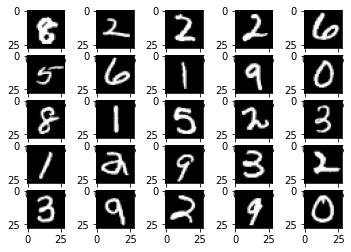

In [11]:
i, (inputs, targets) = next(enumerate(train_dl))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(inputs[i][0], cmap='gray')

plt.show()

In [14]:
print(model)

CNN(
  (hidden1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (hidden2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (hidden3): Linear(in_features=800, out_features=100, bias=True)
  (act3): ReLU()
  (hidden4): Linear(in_features=100, out_features=10, bias=True)
  (act4): Softmax(dim=1)
)


In [18]:
[param.nelement() for param in model.parameters()]

[288, 32, 9216, 32, 80000, 100, 1000, 10]

In [24]:
from torchsummary import summary

In [26]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 32, 11, 11]           9,248
              ReLU-5           [-1, 32, 11, 11]               0
         MaxPool2d-6             [-1, 32, 5, 5]               0
            Linear-7                  [-1, 100]          80,100
              ReLU-8                  [-1, 100]               0
            Linear-9                   [-1, 10]           1,010
          Softmax-10                   [-1, 10]               0
Total params: 90,678
Trainable params: 90,678
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 0.35
Estimated Tot